<a href="https://colab.research.google.com/github/reidnclark/volatility-forecast/blob/main/Q.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
## Import Libraries

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

---
## Parameters

---
## Historical Data Analysis

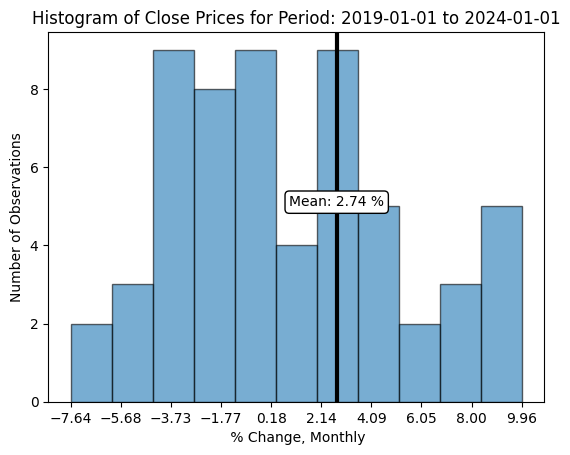

In [ ]:
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# 1) establish variables to store globally
closeprices = None
mean_stockprice = None
sdev_stockprice = None

def gather_data(period_start, period_end, interval_input):

  global closeprices, mean_stockprice, sdev_stockprice

  ticker_histdata = (yf.Ticker(ticker_input)).history(start=period_start, end=period_end, interval=interval_input)
  df_ticker_histdata = pd.DataFrame(ticker_histdata)
  closeprices = df_ticker_histdata['Close']
  mean_stockprice = closeprices.mean()
  sdev_stockprice = closeprices.std()

# CALL FUNCTION LINE:
gather_data(period_start, period_end, interval_input)
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# 1) establish variables to store raw, sorted and formatted variants of pct changes
# (e.g. displayable 2% rather than 0.02 on x-axis)

pct_change_list = None
sorted_pct_change_list = None
formatted_pct_change_list = None

mean_pct_change = None
sdev_pct_change = None
mean_pct_change_lognormal = None
sdev_pct_change_lognormal = None

def compute_weekly_pct_changes(arr):

  global pct_change_list, sorted_pct_change_list, formatted_pct_change_list
  global mean_pct_change, sdev_pct_change, mean_pct_change_lognormal, sdev_pct_change_lognormal

  # calculate pct changes with for loop
  pct_change_list = pd.Series([((arr.iloc[i+1] / arr.iloc[i])) for i in range(len(arr)-1)])
  formatted_pct_change_list = pd.Series([round(((pct_change_list.iloc[i]-1)*100),2) for i in range(len(pct_change_list))])
  sorted_pct_change_list = pct_change_list.sort_values(ascending=True)

  mean_pct_change = pct_change_list.mean()
  sdev_pct_change = pct_change_list.std()

  # establish euler number to calculate for lognormal distribution
  euler_number = 2.71828

  mean_pct_change_lognormal = euler_number ** (mean_pct_change + ((sdev_pct_change**2)/2))
  sdev_pct_change_lognormal = mean_pct_change_lognormal * math.sqrt((euler_number ** (sdev_pct_change**2))-1)


# CALL FUNCTION LINE:
compute_weekly_pct_changes(closeprices)
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------

def plot_results(arr):

    # Use Freedman-Diaconis rule to identify appropriate bin sizing
    inter_quantile_range = arr.quantile(0.75) - arr.quantile(0.25)
    bins_width = 2 * (inter_quantile_range / math.sqrt(len(arr)))
    bins_num = int((np.max(arr) - np.min(arr)) / bins_width)

    plt.hist(arr, bins=(bins_num), edgecolor='black', alpha=0.6)  # Set edgecolor here
    plt.title(f'Histogram of Close Prices for Period: {period_start} to {period_end}')
    text_background_formatting = dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')

    plt.xlabel(' % Change, Monthly')
    plt.xticks(np.linspace(np.min(arr), np.max(arr), num=10))
    plt.ylabel('Number of Observations')


    # plot lognormal mean
    plt.axvline(mean_pct_change_lognormal, linewidth=3, color='black')
    plt.text(mean_pct_change_lognormal,5,f'Mean: {mean_pct_change_lognormal:.2f} %', bbox=text_background_formatting, ha='center')
    # plot lower and upper bollinger bands (set at +/- 2sdev)

    plt.show()

# CALL FUNCTION LINE:
plot_results(formatted_pct_change_list)


#------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Entry Signal: - 17.41 %
Short Signal: + 19.27 %
-----
Mean Price Change per Period: 0.927 %
Standard Deviation: 9.169 %
-----


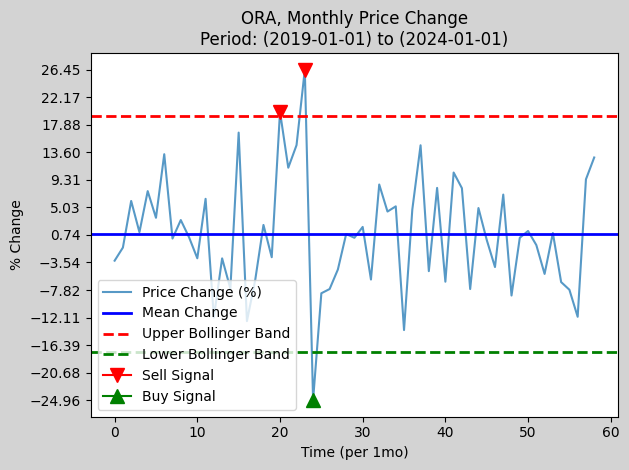

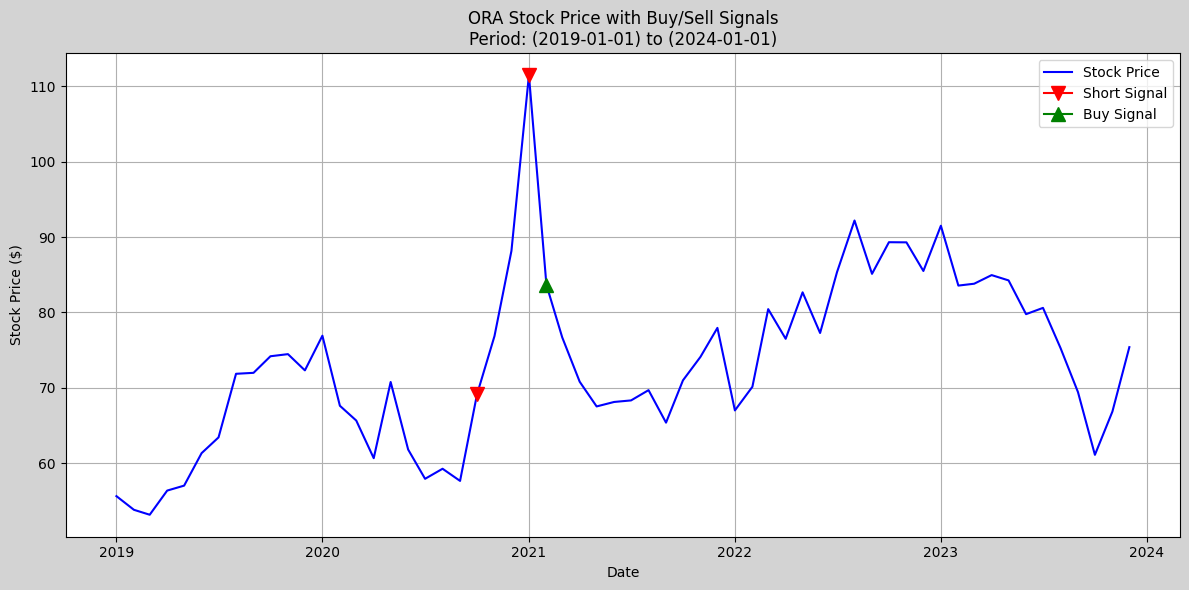

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Inputs
ticker_input = 'ORA'
period_start = '2019-01-01'
period_end = '2024-01-01'
interval_input = '1mo'

# Fetch historical data
ticker_histdata = yf.Ticker(ticker_input).history(start=period_start, end=period_end, interval=interval_input)
df_ticker_histdata = pd.DataFrame(ticker_histdata)

# Extract closing prices
closeprices = df_ticker_histdata['Close']

# Function to calculate rolling percentage changes
def rolling_average(arr):

    chng_list = []

    for i in range(len(arr) - 1):
        chng = round((((arr.iloc[i + 1] / arr.iloc[i]) - 1) * 100), 2)
        chng_list.append(chng)

    return chng_list

chng_list = rolling_average(closeprices)

# Convert change list to a pandas Series for calculations
chng_list = pd.Series(chng_list)
mean_chng = chng_list.mean()
sdev_chng = chng_list.std()

# Identify Bollinger Bands
lower_bollinger = mean_chng - (sdev_chng * 2)
higher_bollinger = mean_chng + (sdev_chng * 2)

# Function to backtest signals
def backtest(arr):
    signals_list = []
    for i in arr:
        if i >= higher_bollinger:
            signals_list.append('Short')
        elif i <= lower_bollinger:
            signals_list.append('Enter')
        else:
            signals_list.append('Do Nothing')
    return signals_list

# Generate signals
signals_list = backtest(chng_list)

# Print signals and statistics
print(f'Entry Signal: - {abs(lower_bollinger):.2f} %')
print(f'Short Signal: + {higher_bollinger:.2f} %')
print('-----')
print(f'Mean Price Change per Period: {mean_chng:.3f} %')
print(f'Standard Deviation: {sdev_chng:.3f} %')
print('-----')

# Create the plot
plt.figure(facecolor='lightgrey')
plt.plot(range(len(chng_list)), chng_list, alpha=0.75, label='Price Change (%)')
plt.axhline(mean_chng, linewidth=2, color='blue', label='Mean Change')
plt.axhline(higher_bollinger, linewidth=2, color='red', linestyle='--', label='Upper Bollinger Band')
plt.axhline(lower_bollinger, linewidth=2, color='green', linestyle='--', label='Lower Bollinger Band')
plt.xlabel(f'Time (per {interval_input})')
plt.ylabel('% Change')
plt.title(f'{ticker_input}, Monthly Price Change\nPeriod: ({period_start}) to ({period_end})')
plt.yticks(np.linspace(np.min(chng_list), np.max(chng_list), num=13))
plt.legend()

# Mark buy and sell signals
for i in range(len(signals_list)):
    if signals_list[i] == 'Enter':
        plt.plot(i, chng_list[i], marker='^', color='green', markersize=10, label='Buy Signal' if 'Buy Signal' not in plt.gca().get_legend_handles_labels()[1] else "")
    elif signals_list[i] == 'Short':
        plt.plot(i, chng_list[i], marker='v', color='red', markersize=10, label='Sell Signal' if 'Sell Signal' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.legend()
plt.tight_layout()
plt.show()

# Additional plot for stock price with signals
plt.figure(figsize=(12, 6), facecolor='lightgrey')
plt.plot(df_ticker_histdata.index, closeprices, label='Stock Price', color='blue')

# Mark buy and sell signals on the stock price plot
for i in range(len(signals_list)):
    if signals_list[i] == 'Enter':
        plt.plot(df_ticker_histdata.index[i + 1], closeprices.iloc[i + 1], marker='^', color='green', markersize=10, label='Buy Signal' if 'Buy Signal' not in plt.gca().get_legend_handles_labels()[1] else "")
    elif signals_list[i] == 'Short':
        plt.plot(df_ticker_histdata.index[i + 1], closeprices.iloc[i + 1], marker='v', color='red', markersize=10, label='Short Signal' if 'Short Signal' not in plt.gca().get_legend_handles_labels()[1] else "")

# Add labels and title for stock price plot
plt.title(f'{ticker_input} Stock Price with Buy/Sell Signals\nPeriod: ({period_start}) to ({period_end})')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# IMPLEMENT WEIGHTED MOVING AVG



In [ ]:
# Prepare for plotting stock price with signals
plt.figure(figsize=(12, 6), facecolor='lightgrey')
plt.plot(dates, closeprices, label='Stock Price', color='blue')

# Mark buy and sell signals
for i in range(len(signals_list)):
    if signals_list[i] == 'Enter':
        plt.plot(dates[i], closeprices.iloc[i + 1], marker='^', color='green', markersize=10, label='Buy Signal' if 'Buy Signal' not in plt.gca().get_legend_handles_labels()[1] else "")
    elif signals_list[i] == 'Short':
        plt.plot(dates[i], closeprices.iloc[i + 1], marker='v', color='red', markersize=10, label='Sell Signal' if 'Sell Signal' not in plt.gca().get_legend_handles_labels()[1] else "")

# Add labels and title
plt.title(f'{ticker_input} Stock Price with Buy/Sell Signals\nPeriod: ({period_start}) to ({period_end})')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

NameError: name 'dates' is not defined

<Figure size 1200x600 with 0 Axes>

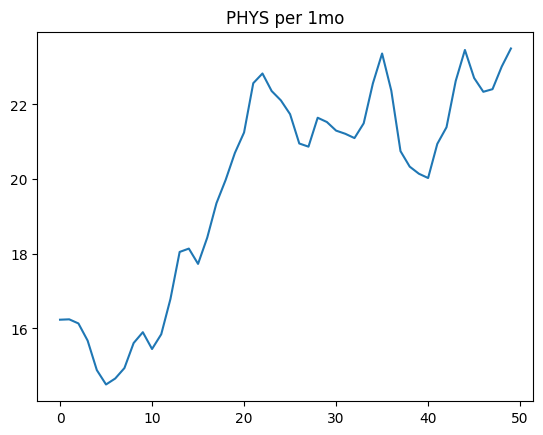

In [ ]:
plt.title(f'{ticker_input} per {interval_input}')
plt.plot(range(len(avg_list)), avg_list)
#plt.plot(range(len(closeprices_new)),closeprices_new)

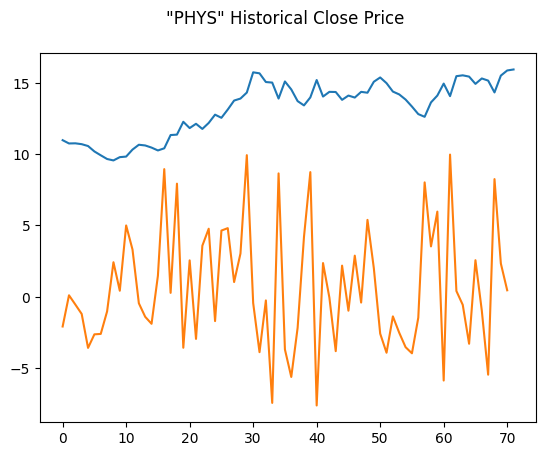

In [ ]:
plt.title(f'"{ticker_input}" Historical Close Price \n')
plt.plot(range(len(closeprices)),closeprices)
plt.plot(range(len(formatted_pct_change_list)),formatted_pct_change_list)
#plt.plt
plt.plot()
plt.show()

---
## **"Gather Data"** Function

In [ ]:
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------
closeprices = None
mean_stockprice = None
sdev_stockprice = None


def gather_data(period_start, period_end, interval_input):

  global closeprices, mean_stockprice, sdev_stockprice

  ticker_histdata = (yf.Ticker(ticker_input)).history(start=period_start, end=period_end, interval=interval_input)
  df_ticker_histdata = pd.DataFrame(ticker_histdata)
  closeprices = df_ticker_histdata['Close']
  mean_stockprice = closeprices.mean()
  sdev_stockprice = closeprices.std()


gather_data(period_start, period_end, interval_input)


#print(f'Length of Close Prices Series: {len(closeprices)}')
#print(f'Most recent observation in Close Price Series: {closeprices.iloc[-1]}')
#print(closeprices)
#print(f'Mean Stock Price: {mean_stockprice}')
#print(f'Standard Deviation of Stock Price: {sdev_stockprice}')
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------

---
## **"Weekly Pct Change"** Function

In [ ]:
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------
weekly_pct_changes_list = None

sorted_weekly_pct_changes = None


mean_weekly_pct_changes = None
sdev_weekly_pct_changes = None

mean_pct_change_lognormal = None
sdev_pct_change_lognormal = None


def compute_weekly_pct_changes(arr):

  global weekly_pct_changes_list, sorted_weekly_pct_changes
  global mean_weekly_pct_changes, sdev_weekly_pct_changes
  global mean_pct_change_lognormal, sdev_pct_change_lognormal

  weekly_pct_changes_list = pd.Series([(arr[i+1] / arr[i]) for i in range(len(arr)-1)])
  sorted_weekly_pctchanges = weekly_pct_changes_list.sort_values(ascending=True)
  mean_weekly_pctchange = weekly_pct_changes_list.mean()
  sdev_weekly_pct_change = weekly_pct_changes_list.std()

  # euler for lognorm distribution
  euler_number = 2.71828
  mean_pct_change_lognormal = euler_number ** (mean_weekly_pctchange + ((sdev_weekly_pct_change**2)/2))
  sdev_pct_change_lognormal = mean_pct_change_lognormal * math.sqrt((euler_number ** (sdev_weekly_pct_change**2))-1)


compute_weekly_pct_changes(closeprices)


#print(lognormal_mean_pctchange)
print(f'For Period {period_start} to {period_end}')
print('------------')
print(f'Formatted Mean (Average) Percentage Change per Week (%, Lognormal):  {round((mean_pct_change_lognormal),2)}%')
print(f'Formatted St.dev Percentage per Week (%, Lognormal):  {round((sdev_pct_change_lognormal),2)}%')
#print(f'Length of Weekly Pct Change Series: {len(weekly_pctchanges)}')
#print(f'NOTE: We have now forfeited the corresponding value at index = 0, since difference gives result at end of diff.')
#print(f'Most recent observation in Weekly Pct Change Series: {weekly_pctchanges[-1]}')
#print(weekly_pctchanges)
#print(type(weekly_pctchanges_calc))
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------

For Period 2018-01-01 to 2023-12-31
------------
Formatted Mean (Average) Percentage Change per Week (%, Lognormal):  2.74%
Formatted St.dev Percentage per Week (%, Lognormal):  0.12%


<ipython-input-156-fb42ac7980a3>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weekly_pct_changes_list = pd.Series([(arr[i+1] / arr[i]) for i in range(len(arr)-1)])


---
## **"Plot"** Function

12


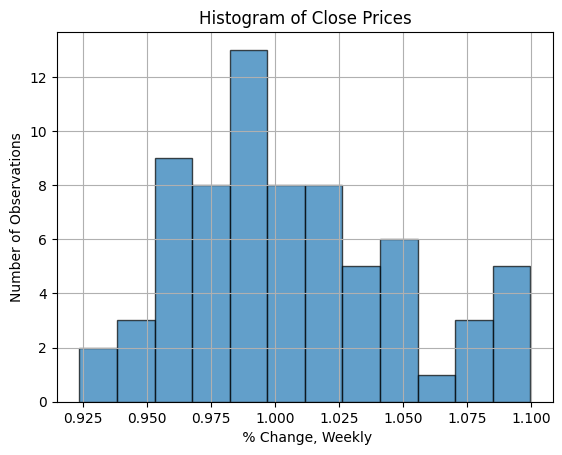

In [ ]:
def plot_results(arr):

    inter_quantile_range = arr.quantile(0.75) - arr.quantile(0.25)
    #print(inter_quantile_range)

    bins_width = 2 * (inter_quantile_range / math.sqrt(len(arr)))
    bins_num = int((np.max(arr) - np.min(arr)) / bins_width)

    print(bins_num)

    plt.hist(arr, bins=(bins_num), edgecolor='black', alpha=0.7)  # Set edgecolor here
    plt.xlabel(' % Change, Weekly')
    plt.ylabel('Number of Observations')
    plt.title('Histogram of Close Prices')
    #plt.axvline(mean_pct_change_lognormal)
    plt.grid(True)

    #plt.axvline(x=mean_pct_change_lognormal, color='red',linewidth=5)
    plt.show()

# Example usage with sample data
# Replace this with your actual close prices array
#closeprices = np.random.lognormal(mean=0, sigma=0.1, size=1000)
plot_results(weekly_pct_changes_list)

In [ ]:
def compute_weekly_pct_changes(arr):

  global weekly_pct_changes_list, sorted_weekly_pct_changes
  global mean_weekly_pct_changes, sdev_weekly_pct_changes
  global mean_pct_change_lognormal, sdev_pct_change_lognormal

  weekly_pct_changes_list = pd.Series([(arr[i+1] / arr[i]) for i in range(len(arr)-1)])
  sorted_weekly_pct_changes = weekly_pct_changes_list.sort_values(ascending=True)
  mean_weekly_pctchange = weekly_pct_changes_list.mean()
  sdev_weekly_pct_change = weekly_pct_changes_list.std()

  # euler for lognorm distribution
  euler_number = 2.71828
  mean_pct_change_lognormal = euler_number ** (mean_weekly_pctchange + ((sdev_weekly_pct_change**2)/2))
  sdev_pct_change_lognormal = mean_pct_change_lognormal * math.sqrt((euler_number ** (sdev_weekly_pct_change**2))-1)

  return sorted_weekly_pct_changes # return the sorted Series

sorted_weekly_pct_changes = compute_weekly_pct_changes(closeprices) # assign the returned Series

<ipython-input-158-5918279d35c8>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weekly_pct_changes_list = pd.Series([(arr[i+1] / arr[i]) for i in range(len(arr)-1)])
